In [1]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
EPOCH = 50
IMAGE_SIZE = 224
CHANNELS = 3
BATCH_SIZE = 32 
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "../data/formatted/224_formatted", 
    seed = 123,
    shuffle=True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size = BATCH_SIZE
)

Found 912 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['healthy_coral', 'sctld_coral']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(f"random batch shape: {image_batch.shape}")

random batch shape: (32, 224, 224, 3)


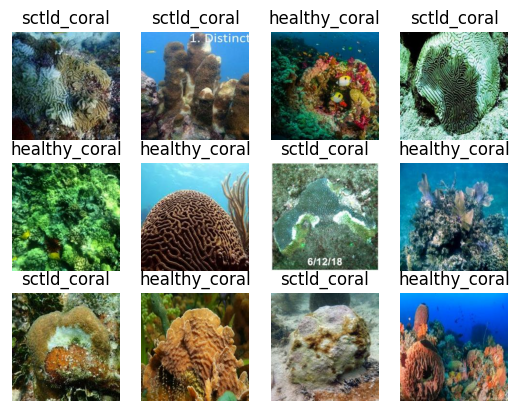

In [8]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12): 
        ax = plt.subplot(3,4,i+1) 
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
      

In [15]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size=1000): 
    assert (train_split + test_split + val_split == 1)
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds =  dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(test_ds)

4

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [33]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.1)
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 222, 222, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 111, 111, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 109, 109, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 54, 54, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 52, 52, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 26, 26, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 24, 24, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 12, 12, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 10, 10, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 5, 5, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 3, 3, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 1, 1, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 2)                     │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,394 (669.51 KB)

 Trainable params: 171,394 (669.51 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.metrics import *
metrics = ['accuracy']
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=metrics 
)

from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=5,              # Number of epochs to wait for improvement before stopping
    mode='max',              # Look for maximum value (for accuracy)
    restore_best_weights=True # Restore the weights of the best epoch
)


In [37]:
for image_batch, labels_batch in dataset.take(1): 
    print(image_batch.shape)
    print(labels_batch)

(32, 224, 224, 3)
tf.Tensor([1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1], shape=(32,), dtype=int32)


In [38]:
history= model.fit(
    train_ds,
    epochs = EPOCH,
    batch_size = BATCH_SIZE, 
    verbose = 1, 
    validation_data = val_ds,
    # callbacks=[early_stopping]
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 916ms/step - accuracy: 0.5071 - loss: 0.6958 - val_accuracy: 0.6250 - val_loss: 0.6920
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 874ms/step - accuracy: 0.5382 - loss: 0.6891 - val_accuracy: 0.4844 - val_loss: 0.6755
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 880ms/step - accuracy: 0.6136 - loss: 0.6434 - val_accuracy: 0.8281 - val_loss: 0.4743
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 873ms/step - accuracy: 0.7088 - loss: 0.5628 - val_accuracy: 0.7812 - val_loss: 0.4463
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 868ms/step - accuracy: 0.7066 - loss: 0.5611 - val_accuracy: 0.7344 - val_loss: 0.5041
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 888ms/step - accuracy: 0.7467 - loss: 0.5209 - val_accuracy: 0.8125 - val_loss: 0.3966
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 865ms/step - accuracy: 0.7696 - loss: 0.5051 - val_accuracy: 0.7344 - val_loss: 0.4958
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 897ms/step - accuracy: 0.7369 - loss: 0.5343 - val_accu

score = model.evaluate(test_ds)

In [39]:
model.evaluate(test_ds)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.8317 - loss: 0.4245


[0.44624289870262146, 0.8125]

In [27]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

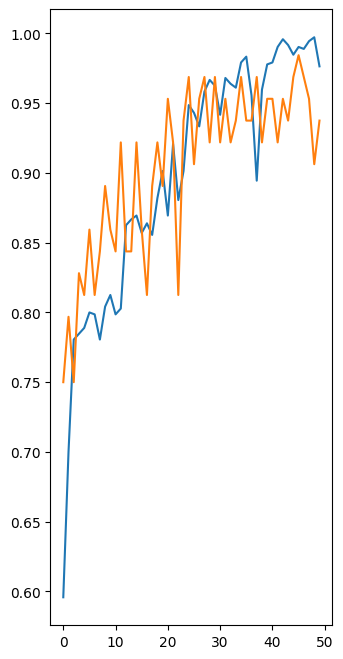

In [30]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(50), accuracy, label ='TRAINING ACCURACY')
plt.plot(range(50), val_accuracy, label = 'VALIDATION ACCURACY')


In [56]:
def predict(model, img): 
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis = 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence 

In [71]:
from PIL import Image
image_path = "../../CoralBase/testing4.jpg"  # Replace with your actual path

# Open the image
img = Image.open(image_path)

predict(model, img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


('sctld_coral', 100.0)

FIRST PREDICTED IMAGE
ACTUAL LABEL:  healthy_coral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
IMAGE_PREDICTION:  healthy_coral


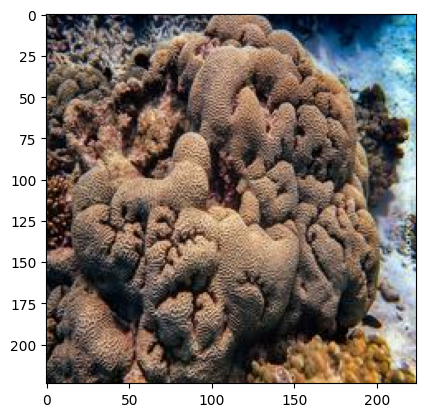

In [36]:
for image_batch, label_batch in test_ds.take(1): 
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()
    print("FIRST PREDICTED IMAGE")
    print("ACTUAL LABEL: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    image_prediction = class_names[batch_prediction[0].argmax()]
    print("IMAGE_PREDICTION: ", image_prediction)
    plt.imshow(image_batch[0].numpy().astype("uint8"))

In [ ]:
image = 
predicted_class, confidence = predict(model, images[i].numpy())

In [1]:



def predict(model, img): 
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, axis = 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence 
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    batch_size = images.shape[0]
    print(f"Batch size: {batch_size}")
   # plt.imshow(images.numpy().astype("uint8"))
    for i in range(32):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual {actual_class}, \n Predicted: {predicted_class}, \n confidence: {confidence}")
        plt.axis("off")
        


NameError: name 'plt' is not defined

In [41]:
from tensorflow.keras.models import load_model

model_version = 2
model.save(f"../models/{model_version}.keras")
model.save_weights(f"../models/{model_version}_weights.weights.h5")